In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import scipy as sc
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import astropy
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from astropy.coordinates import SkyCoord
import astropy.units as u
import pickle

Displaying dataframe of all matched files, calculating redshift difference and average redshift of each match, as well as calculating angular separation between eFEDS AGN coordinates and SDSS coordinates:

In [18]:
with fits.open('./data/matched.fits') as hdul:
    agn_ra = list(hdul[1].data['AGN_RA_CORR'])
    agn_dec = list(hdul[1].data['AGN_DEC_CORR'])
    catalog_ra = list(hdul[1].data['CATALOG_RA'])
    catalog_dec = list(hdul[1].data['CATALOG_DEC'])
    p_any = list(hdul[1].data['p_any'])
    catalog_plate = list(hdul[1].data['CATALOG_PLATE'])
    catalog_mjd = list(hdul[1].data['CATALOG_MJD'])
    catalog_fiberid = list(hdul[1].data['CATALOG_FIBERID'])
    eFEDS_redshift = np.round(list(hdul[1].data['AGN_CTP_REDSHIFT']),6)
    sdss_redshift = np.round(list(hdul[1].data['CATALOG_Z_VI']),6)
    ctp_id = list(hdul[1].data['AGN_CTP_LS8_UNIQUE_OBJID'])
    agn_id = list(hdul[1].data['AGN_ID_SRC'])
    sdss_id = list(hdul[1].data['CATALOG_OBJID'])
    match_flag = list(hdul[1].data['match_flag'])
    inarea90 = hdul[1].data['AGN_inArea90']
    agn_ctp_quality = list(hdul[1].data['AGN_CTP_quality'])
    det_like = list(hdul[1].data['AGN_DET_LIKE'])
    soft_lum = list(hdul[1].data['AGN_LumiIntr_Med_s'])
    ctp_redshift_grade = list(hdul[1].data['AGN_CTP_REDSHIFT_GRADE'])
    ctp_class = list(hdul[1].data['AGN_CTP_CLASS'])
    best_redshift = np.round(list(hdul[1].data['CATALOG_Z']),6)
    n_h = list(hdul[1].data['AGN_lognH_Med_m1'])
    
match_df = pd.DataFrame({'SDSS_ID': sdss_id,'agn_id':agn_id, 'eFEDS_REDSHIFT': eFEDS_redshift,
                         'best_REDSHIFT': best_redshift, 'AGN_RA': agn_ra, 'AGN_DEC': agn_dec, 'CATALOG_RA': catalog_ra,
                         'CATALOG_DEC': catalog_dec, 'p_any': p_any, 'CATALOG_PLATE':catalog_plate,
                         'CATALOG_MJD': catalog_mjd, 'CATALOG_FIBERID': catalog_fiberid,
                         'match_flag': match_flag, 'inarea90':inarea90, 'ctp_quality': agn_ctp_quality,
                         'det_like':det_like, 'ctp_redshift_grade': ctp_redshift_grade, 'ctp_class': ctp_class, 'N_H': n_h,
                         'SOFT_LUMINOSITY': soft_lum})
match_df.drop(match_df[match_df['CATALOG_PLATE']==-99].index, inplace=True)
#match_df.drop(match_df[match_df['inarea90']== False].index, inplace=True)                         
match_df.reset_index(drop=True, inplace=True)
#matched_df = match_df[(match_df['p_any']>0.995) & (match_df['det_like']>10)]
updated_df = match_df.copy()
updated_df['redshift_difference'] = np.round(np.abs(updated_df['eFEDS_REDSHIFT'] - updated_df['best_REDSHIFT']),6)
updated_df['average_redshift'] = np.round((updated_df['eFEDS_REDSHIFT'] + updated_df['best_REDSHIFT'])/2,6)
#updated_df.drop([33,36,360,363,384], inplace=True)

sdss_ra = list(updated_df['CATALOG_RA'])
sdss_dec = list(updated_df['CATALOG_DEC'])
agn_ra = list(updated_df['AGN_RA'])
agn_dec = list(updated_df['AGN_DEC'])

ang_sep = []
for i in range (len(agn_ra)):
    coord1 = SkyCoord(ra = agn_ra[i]*u.degree, dec = agn_dec[i]*u.degree, frame='icrs')  
    coord2 = SkyCoord(ra = sdss_ra[i]*u.degree, dec = sdss_dec[i]*u.degree, frame='icrs')  

    angular_separation = coord1.separation(coord2)
    ang_sep.append(angular_separation.degree*3600)


updated_df.insert(8, 'Angular_sep', ang_sep)
ang_sep = np.array(ang_sep)
updated_df

,SDSS_ID,agn_id,eFEDS_REDSHIFT,best_REDSHIFT,AGN_RA,AGN_DEC,CATALOG_RA,CATALOG_DEC,Angular_sep,p_any,...,match_flag,inarea90,ctp_quality,det_like,ctp_redshift_grade,ctp_class,N_H,SOFT_LUMINOSITY,redshift_difference,average_redshift
0,1237650795143233717,7,0.322346,0.322247,139.259589,-0.737505,139.259950,-0.738209,2.849441,9.949045e-01,...,1,True,4,9961.442383,5,3,19.731468,44.635399,0.000099,0.322297
1,1237658423544447024,8,2.871900,0.301766,138.501628,5.114248,138.507332,5.130723,62.738795,7.621726e-07,...,1,True,4,203.909912,3,2,20.613472,45.996899,2.570134,1.586833
2,1237658423544447024,9,0.301340,0.301766,138.507473,5.130530,138.507332,5.130723,0.861437,9.950856e-01,...,1,True,4,9294.518555,5,3,19.821041,44.713902,0.000426,0.301553
3,1237654601554985045,11,0.512114,0.512223,130.762335,3.038443,130.762376,3.038584,0.528216,9.950967e-01,...,1,True,4,7421.844727,5,3,19.869638,45.120800,0.000109,0.512168
4,1237673709868417096,24,1.024224,1.024000,137.292668,1.359825,137.292037,1.359892,2.282854,9.949766e-01,...,1,True,4,3807.828613,5,3,20.132584,45.508400,0.000224,1.024112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3032,1237654605317669312,32302,2.472200,2.337000,141.619566,3.532273,141.614646,3.534769,19.829209,9.669534e-01,...,1,True,2,6.884191,4,2,21.774380,43.139900,0.135200,2.404600
3033,1237658492793913717,32306,2.338644,2.338000,128.652889,5.776593,128.655375,5.777166,9.142580,9.926254e-01,...,1,False,4,6.629631,5,3,21.241119,44.858501,0.000644,2.338322
3034,1237658300595044784,32488,0.379500,1.947841,129.295446,5.141444,129.292031,5.133709,30.419491,6.798891e-01,...,1,True,4,6.138684,4,2,21.976753,42.148800,1.568341,1.163671
3035,1237650795674993112,32533,2.073045,2.070000,127.609690,-0.402544,127.609678,-0.403802,4.526629,9.945859e-01,...,1,True,4,7.232318,5,3,21.154482,44.336300,0.003045,2.071523


Plot showing why we dropped angular separation >=30":

Text(0, 0.5, 'p_any')

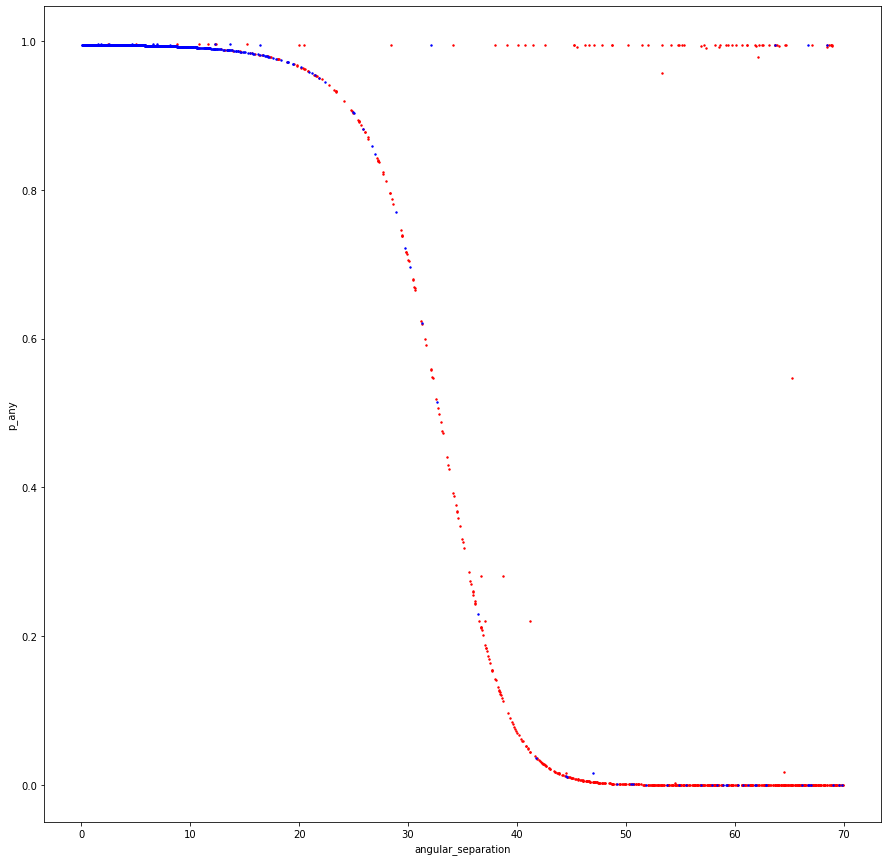

In [72]:
plt.figure(figsize=(15,15))
plt.scatter(ang_sep[updated_df['redshift_difference']>0.1], updated_df['p_any'][updated_df['redshift_difference']>0.1], color='red', s=2)
plt.xlabel('angular_separation')
plt.scatter(ang_sep[updated_df['redshift_difference']<=0.1], updated_df['p_any'][updated_df['redshift_difference']<=0.1], color='blue', s=2)
plt.ylabel('p_any')

Dropping duplicates, and creating lists which will be used for webscraping the spectra:

In [3]:
updated_df_no_duplicates = updated_df.drop_duplicates(subset='SDSS_ID', keep='first')
updated_id = list(updated_df_no_duplicates['SDSS_ID'])
plate_list = []
mjd_list = []
fiber_list = []
redshift_difference_list =[]
for sdss_id in updated_id:
    row = updated_df_no_duplicates[updated_df_no_duplicates['SDSS_ID'] == sdss_id]
    plate_value = row['CATALOG_PLATE'].values[0]
    mjd_value = row['CATALOG_MJD'].values[0]
    fiber_value = row['CATALOG_FIBERID'].values[0]
    red = row['redshift_difference'].values[0]
    plate_list.append(plate_value)
    mjd_list.append(mjd_value)
    fiber_list.append(fiber_value)
    redshift_difference_list.append(red)

In [4]:
listtw = updated_id[:3]
plate_listw = plate_list[:3]

Donwloading the spectra:

In [20]:
driver = webdriver.Safari()
url = 'https://skyserver.sdss.org/dr18/VisualTools/explore/summary?id=1237674462026465450'
driver.get(url)
driver.maximize_window()
jw=0
for l in range(0, len(listtw)):
 
    search = driver.find_element(By.ID, 'searchLabel')
    search.click()

 
    input_field = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.ID, 'exploreId')))
    input_field.clear()
    time.sleep(0.5)
    input_field.send_keys(listtw[l])
    input_field.send_keys(Keys.RETURN)
    time.sleep(2)
    new = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.ID, 'ImagingCardHeader'))
    )
    new.click()
    time.sleep(2)
    neww = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.ID, 'SpectroCardHeader'))
    )
    neww.click()
    time.sleep(1)
    plate_value_element = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//th[span[text()='plate']]/following-sibling::td"))
    )

    current_plate_value = plate_value_element.text.strip()
    time.sleep(1.5)
    window1 = driver.current_window_handle
    if int(current_plate_value) == plate_listw[l]:

        p = driver.find_element(By.LINK_TEXT, 'FITS')
        p.click()
        time.sleep(2)
        WebDriverWait(driver, 10).until(EC.number_of_windows_to_be(2)) 
        for window in driver.window_handles:
            if window != window1:
                driver.switch_to.window(window)  
                break
        time.sleep(1)

        download_link = WebDriverWait(driver, 20).until(
            EC.visibility_of_element_located((By.XPATH, "//p[contains(text(), 'Spectrum FITS file')]/a[@class='content']"))
        )
        time.sleep(1)
        download_link.click()
        time.sleep(5)

        driver.close()
        time.sleep(2)
        driver.switch_to.window(window1)
        jw+=1
    
    else:
        s = driver.find_element(By.LINK_TEXT, 'All Spectra')
        s.click()
        time.sleep(2)
        WebDriverWait(driver, 10).until(EC.number_of_windows_to_be(2))
        for window in driver.window_handles:
            if window != window1:
                driver.switch_to.window(window) 
                break
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//table[@class='table table-bordered table-responsive']"))
        )


        rows = driver.find_elements(By.XPATH, "//table[@class='table table-bordered table-responsive']//tbody/tr")

 
        for row in rows:
            
            plate_td = row.find_element(By.XPATH, "./td[2]")  
            plate_value = plate_td.text.strip()

            print(plate_value)
            if int(plate_value) == plate_listw[l]:
                time.sleep(2)

                first_td = row.find_element(By.TAG_NAME, "a")
                first_td.click()
                time.sleep(2)
                break
        for window in driver.window_handles:
            if window != window1:
                driver.switch_to.window(window) 
                break
        time.sleep(1)
        new = driver.find_element(By.ID, 'ImagingCardHeader')
        new.click()
        time.sleep(2)

        neww = driver.find_element(By.ID, 'SpectroCardHeader')
        neww.click()
        time.sleep(2)
        p = driver.find_element(By.LINK_TEXT, 'FITS')
        p.click()
        time.sleep(2)
        driver.close()
        time.sleep(2)
        for window in driver.window_handles:
            if window != window1:
                driver.switch_to.window(window) 
                break
        time.sleep(1)
        download_link = WebDriverWait(driver, 20).until(
            EC.visibility_of_element_located((By.XPATH, "//p[contains(text(), 'Spectrum FITS file')]/a[@class='content']"))
        )  
        time.sleep(1)
        download_link.click()
        time.sleep(5)

        driver.close()
        time.sleep(2)
        driver.switch_to.window(window1)
        jw+=1
    print(jw)
            
driver.quit()

3821
472
1
2
3
4
5


Creating list of downloaded spectra and creating ammended list that contains only files where the redshift difference is < 0.1:

In [68]:
files_original = glob.glob('./data/spec*.fits')
files = []
files_outliers = []
for filee in files_original:
    number = len(
    updated_df[
        (updated_df['CATALOG_PLATE'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[1])) & 
         (updated_df['CATALOG_MJD'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[2])) &
            (updated_df['CATALOG_FIBERID'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[3])) &
        (updated_df['redshift_difference']<0.1) & (updated_df['Angular_sep']<30)])
    
    number_outliers = len(
    updated_df[
        (updated_df['CATALOG_PLATE'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[1])) & 
         (updated_df['CATALOG_MJD'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[2])) &
            (updated_df['CATALOG_FIBERID'] == int(os.path.splitext(os.path.basename(filee))[0].split('-')[3])) &
        (updated_df['redshift_difference']>=0.1) & (updated_df['Angular_sep']<30)])
    if (number)>0:
            files.append(filee)
    if (number==0) & (number_outliers>0):
            files_outliers.append(filee)

In [69]:
len(files_original)

2699

In [70]:
len(files)

2232

In [71]:
len(files_outliers)

155

Retrieving information of downloaded spectra:

In [73]:
flux_tot = []
loglam_tot = []
lam_tot = []
names = []
ivar_tot = []
std_dev_tot = []
and_mask_tot = []
or_mask_tot = []
for file in files:
    with fits.open(file) as hdul:
        flux_tot.append(hdul[1].data['flux'])
        loglam_tot.append(hdul[1].data['loglam'])
        lam_tot.append(10**hdul[1].data['loglam'])
        ivare = hdul[1].data['ivar']
        and_mask = hdul[1].data['and_mask']
        or_mask = hdul[1].data['or_mask']
        ivar_tot.append(ivare)
        std = np.where(ivare > 0, 1 / np.sqrt(ivare), np.inf)
        std_dev_tot.append(std)
        names.append(os.path.splitext(os.path.basename(file))[0])
        and_mask_tot.append(and_mask)
        or_mask_tot.append(or_mask)
names = np.array(names)

<ipython-input-73-d52b4cedea70>:18: RuntimeWarning: divide by zero encountered in true_divide
  std = np.where(ivare > 0, 1 / np.sqrt(ivare), np.inf)


In [74]:
rest_lam_tot = []
redshifts = []
n_hs = []
for i in range (0,len(lam_tot)):
    t = updated_df[(updated_df['CATALOG_PLATE']==int(names[i].split('-')[1])) & 
                            (updated_df['CATALOG_MJD']==int(names[i].split('-')[2])
                            ) & 
                            (updated_df['CATALOG_FIBERID']==int(names[i].split('-')[3]))].nsmallest(1, 'redshift_difference')
    tt = t['best_REDSHIFT'].iloc[0]
    q = updated_df[(updated_df['CATALOG_PLATE']==int(names[i].split('-')[1])) & 
                            (updated_df['CATALOG_MJD']==int(names[i].split('-')[2])) & 
                            (updated_df['CATALOG_FIBERID']==int(names[i].split('-')[3]))].nsmallest(1, 'redshift_difference')
    qq = q['N_H'].iloc[0]
    redshifts.append(tt)
    rest_wavelength_range = lam_tot[i]/(1+tt)
    rest_lam_tot.append(rest_wavelength_range)
    n_hs.append(qq)
redshifts = np.array(redshifts)
n_hs = np.array(n_hs)

Normalising the flux:

In [75]:
flux_norm_tot = []
ivar_norm_tot = []
std_dev_norm_tot = []
for i in range(0, len(flux_tot)):
    area = np.trapz(flux_tot[i], rest_lam_tot[i])
    flux_norm_tot.append(flux_tot[i]/area)
    ivar_norm_tot.append(ivar_tot[i]*area**2)
    std_dev_norm_tot.append(std_dev_tot[i]/area)

Creating a dictionary of this information to be imported to the spectra notebook:

In [76]:
dictionary = {'names': names, 'flux_tot': flux_tot, 'loglam_tot': loglam_tot, 'lam_tot': lam_tot, 'ivar_tot': ivar_tot,
             'std_dev_tot': std_dev_tot, 'rest_lam_tot': rest_lam_tot, 'redshifts': redshifts, 'n_hs': n_hs, 'flux_norm_tot': flux_norm_tot, 'ivar_norm_tot': ivar_norm_tot, 'std_dev_norm_tot': std_dev_norm_tot}

with open('spectra_info.pkl', 'wb') as file:
    pickle.dump(dictionary, file)

Same process for outlier spectra:

In [81]:
def efeds_redshift(filee):
    t = updated_df[(updated_df['CATALOG_PLATE']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[1])) & 
                            (updated_df['CATALOG_MJD']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[2])) & 
                            (updated_df['CATALOG_FIBERID']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[3]))].nlargest(1, 'p_any')
    return t['eFEDS_REDSHIFT'].iloc[0]
def sdss_redshift(filee):
    t = updated_df[(updated_df['CATALOG_PLATE']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[1])) & 
                            (updated_df['CATALOG_MJD']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[2])) & 
                            (updated_df['CATALOG_FIBERID']== int(os.path.splitext(os.path.basename(filee))[0].split('-')[3]))].nlargest(1, 'p_any')
    return t['best_REDSHIFT'].iloc[0]
outlier_eFEDS_redshifts = [efeds_redshift(file) for file in files_outliers]
outlier_SDSS_redshifts = [sdss_redshift(file) for file in files_outliers]

In [82]:
flux_outlier_tot = []
loglam_outlier_tot = []
lam_outlier_tot = []
names_outlier = []
for file in files_outliers:
    with fits.open(file) as hdul:
        flux_outlier_tot.append(hdul[1].data['flux'])
        loglam_outlier_tot.append(hdul[1].data['loglam'])
        lam_outlier_tot.append(10**hdul[1].data['loglam'])
        names_outlier.append(os.path.splitext(os.path.basename(file))[0])
names_outlier = np.array(names_outlier)

In [83]:
dictionary_outliers = {'names_outlier': names_outlier, 'flux_outlier_tot': flux_outlier_tot, 'loglam_outlier_tot': loglam_outlier_tot,
                      'lam_outlier_tot': lam_outlier_tot, 'outlier_eFEDS_redshifts': outlier_eFEDS_redshifts, 'outlier_SDSS_redshifts': outlier_SDSS_redshifts}

In [84]:
with open('outlier_spectra_info.pkl', 'wb') as file:
    pickle.dump(dictionary_outliers, file)

The following 3 spectra combination are simple average with the standard deviation of the average, a weighted average with the weighted error in mean, and the median with the corresponding standard deviation of that median flux value. We cut off the wavelengths of these spectra so that in each redshift bin, every spectrum has a flux value at each wavelength of the average spectra:

# Spectra combination 1: simple average with cut-off wavelengths

Creating function that defines all these spectra across a wavelength range that they all occupy, and returns the flux of each spectra across this wavelength range, with all the new flux lists having the same length as the wavelength range so they can be added together. The function also returns a 2d list of the indexs across each redshift bin, a 2d list of the wavelengths for each redshift bin, and a 2d list of the summed flux for each redshift bin:

In [85]:
def average(x):
    average_flux = []
    std_devi = []
    
    for i in range(len(x[0])):
        c1= []
        for j in range(len(x)):
            c1.append(x[j][i])
        av = np.mean(c1)
        stan = np.std(c1)
        
        average_flux.append(av)
        std_devi.append(stan)
        
    return average_flux, std_devi

indexs1_unobscured = []
final_fluxs1_unobscured = []
final_wavelengths1_unobscured = []
final_stddevs1_unobscured = []
text1_unobscured = []

indexs1_obscured = []
final_fluxs1_obscured = []
final_wavelengths1_obscured = []
final_stddevs1_obscured = []
text1_obscured = []



for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    if i == 0.2:
        indexx = [e for e in index if rest_lam_tot[e][-1]>6800]
        index_unobscured = [t for t in indexx if n_hs[t] < 22]
        index_obscured = [t for t in indexx if n_hs[t] >= 22]
    if len(index_unobscured) > 0:
            
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_unobscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_unobscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_unobscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)
        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        for t in index_unobscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
        average_fluxs, stddev = average(new_fluxs)
        indexs1_unobscured.append(np.array(index_unobscured))
        final_fluxs1_unobscured.append(np.array(average_fluxs))
        final_stddevs1_unobscured.append(np.array(stddev))
        final_wavelengths1_unobscured.append(new_wavelengths)
        text1_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths1_unobscured.append(new_wavelengths)
        final_fluxs1_unobscured.append(np.zeros(6001))
        indexs1_unobscured.append(np.array([]))
        final_stddevs1_unobscured.append(np.zeros(6001))
        text1_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    if len(index_obscured) > 0:
            
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_obscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_obscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_obscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)
        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        for t in index_obscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
        average_fluxs, stddev = average(new_fluxs)
        indexs1_obscured.append(np.array(index_obscured))
        final_fluxs1_obscured.append(np.array(average_fluxs))
        final_stddevs1_obscured.append(np.array(stddev))
        final_wavelengths1_obscured.append(new_wavelengths)
        text1_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths1_obscured.append(new_wavelengths)
        final_fluxs1_obscured.append(np.zeros(6001))
        indexs1_obscured.append(np.array([]))
        final_stddevs1_obscured.append(np.zeros(6001))
        text1_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')

# Spectra combination 2: weighted average + weighted std-dev with cut-off wavelengths

In [86]:
def addding(flux, ivar):
    b1 = []
    for i in range(len(flux[0])):
        c1=0
        s1=0
        for j in range(len(flux)):
            c1 += flux[j][i]*ivar[j][i]
            s1 += ivar[j][i]
        if s1 ==0:
            b1.append(0)
        else:
            b1.append(c1/s1)
    return b1
    
def uncert(ivar):
    b2 = []
    for i in range(len(ivar[0])):
        c2=0
        for j in range(len(ivar)):
            c2 += ivar[j][i]
        if c2 != 0:
            b2.append(1/np.sqrt(c2))
        else:
            b2.append(0)
    return b2   
indexs2_unobscured = []
final_fluxs2_unobscured = []
final_wavelengths2_unobscured = []
final_uncertainties2_unobscured = []
text2_unobscured = []

indexs2_obscured = []
final_fluxs2_obscured = []
final_wavelengths2_obscured = []
final_uncertainties2_obscured = []
text2_obscured = []


for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    if i == 0.2:
        indexx = [e for e in index if rest_lam_tot[e][-1]>6800]
        index_unobscured = [t for t in indexx if n_hs[t] < 22]
        index_obscured = [t for t in indexx if n_hs[t] >= 22]
    if len(index_unobscured) > 0:
        
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_unobscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_unobscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_unobscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)

        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        ivars = []
        for t in index_unobscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            v = np.array(ivar_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
            ivars.append(v)
        sum_fluxs = addding(new_fluxs, ivars)
        sum_unc = uncert(ivars)
        indexs2_unobscured.append(np.array(index_unobscured))
        final_fluxs2_unobscured.append(np.array(sum_fluxs))
        final_wavelengths2_unobscured.append(new_wavelengths)
        final_uncertainties2_unobscured.append(np.array(sum_unc))
        text2_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
    
    else:
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths2_unobscured.append(new_wavelengths)
        final_fluxs2_unobscured.append(np.zeros())
        indexs2_unobscured.append(np.array([]))
        final_uncertainties2_unobscured.append(np.zeros(6001))
        text2_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
  
    if len(index_obscured) > 0:
        
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_obscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_obscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_obscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)
        if np.round(i,1) == 0.6:
            ppq = wavelength_min
            ppqq = mini
        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        ivars = []
        for t in index_obscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            v = np.array(ivar_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
            ivars.append(v)
        sum_fluxs = addding(new_fluxs, ivars)
        sum_unc = uncert(ivars)
        indexs2_obscured.append(np.array(index_obscured))
        final_fluxs2_obscured.append(np.array(sum_fluxs))
        final_wavelengths2_obscured.append(new_wavelengths)
        final_uncertainties2_obscured.append(np.array(sum_unc))
        text2_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
    
    else:
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths2_obscured.append(new_wavelengths)
        final_fluxs2_obscured.append(np.zeros(6001))
        indexs2_obscured.append(np.array([]))
        final_uncertainties2_obscured.append(np.zeros(6001))
        text2_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')

# Spectra combination 3: median + median standard deviation with cut-off wavelengths

In [87]:
def median(x, ivars):
    median_flux = []
    median_std = []
    for i in range(len(x[0])):
        kk = []
        nn = []
        for j in range(len(x)):
            kk.append(x[j][i])
            nn.append(ivars[j][i])
        s = np.array(kk)[np.argsort(kk)]
        b = np.array(nn)[np.argsort(kk)]
        if len(s)/2 == 0:
            ind = int(len(s)/2 -1)
        else:
            ind = int((len(s)-1)/2)
        median_flux.append(s[ind])
        if b[ind] != 0:
            median_std.append(1/np.sqrt(b[ind]))
        else:
            median_std.append(-5)
    return median_flux, median_std

indexs3_unobscured = []
final_fluxs3_unobscured = []
final_wavelengths3_unobscured = []
final_uncertainties3_unobscured = []
text3_unobscured = []

indexs3_obscured = []
final_fluxs3_obscured = []
final_wavelengths3_obscured = []
final_uncertainties3_obscured = []
text3_obscured = []


for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    if i == 0.2:
        indexx = [e for e in index if rest_lam_tot[e][-1]>6800]
        index_unobscured = [t for t in indexx if n_hs[t] < 22]
        index_obscured = [t for t in indexx if n_hs[t] >= 22]
    if len(index_unobscured) > 0:
        
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_unobscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_unobscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_unobscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)

        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        ivars = []
        for t in index_unobscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            v = np.array(ivar_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
            ivars.append(v)
        sum_fluxs, sum_unc = median(new_fluxs, ivars)
        indexs3_unobscured.append(np.array(index_unobscured))
        final_fluxs3_unobscured.append(np.array(sum_fluxs))
        final_wavelengths3_unobscured.append(new_wavelengths)
        final_uncertainties3_unobscured.append(np.array(sum_unc))
        text3_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
    
    else:
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths3_unobscured.append(new_wavelengths)
        final_fluxs3_unobscured.append(np.zeros(6001))
        indexs3_unobscured.append(np.array([]))
        final_uncertainties3_unobscured.append(np.zeros(6001))
        text3_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
  
    if len(index_obscured) > 0:
        
        wavelength_min_list = [rest_lam_tot[p][0] for p in index_obscured ]
        wavelength_min = np.max(wavelength_min_list)
        wavelength_max_list = [rest_lam_tot[p][-1] for p in index_obscured ]
        wavelength_max = np.min(wavelength_max_list)
        kk = []
        for t in index_obscured:
            test_wavelengths = rest_lam_tot[t][(rest_lam_tot[t]>wavelength_min) & (rest_lam_tot[t]<wavelength_max)]
            kk.append(test_wavelengths)
        lenfs = [len(jj) for jj in kk]
        mini = np.min(lenfs)
        a = lenfs.index(min(lenfs))
        new_wavelengths= kk[a]
        new_fluxs = []
        ivars = []
        for t in index_obscured:
            f = np.array(flux_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            v = np.array(ivar_tot[t])[rest_lam_tot[t]>wavelength_min][0:mini]
            new_fluxs.append(f)
            ivars.append(v)
        sum_fluxs, sum_unc = median(new_fluxs, ivars)
        indexs3_obscured.append(np.array(index_obscured))
        final_fluxs3_obscured.append(np.array(sum_fluxs))
        final_wavelengths3_obscured.append(new_wavelengths)
        final_uncertainties3_obscured.append(np.array(sum_unc))
        text3_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
    
    else:
        new_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths3_obscured.append(new_wavelengths)
        final_fluxs3_obscured.append(np.zeros(6001))
        indexs3_obscured.append(np.array([]))
        final_uncertainties3_obscured.append(np.zeros(6001))
        text3_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')

The following 3 methods are the same, but with no cut off wavelengths, the average spectrum is calculated based on how many spectra contribute at each wavelength:

# Spectra combination 4: simple average

In [88]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def new_average(x):
    average_flux = []
    std_devi = []
    
    for i in range(len(x[0])):
        c1= []
        for j in range(len(x)):
            c1.append(x[j][i])
        c1 = np.array(c1)
        av = np.mean(c1[c1 != 0])
        stan = np.std(c1[c1 != 0])
        
        average_flux.append(av)
        std_devi.append(stan)
        
    return average_flux, std_devi

indexs_sim_unobscured = []
final_fluxs_sim_unobscured = []
final_wavelengths_sim_unobscured = []
final_stddevs_sim_unobscured = []
text_sim_unobscured = []

indexs_sim_obscured = []
final_fluxs_sim_obscured = []
final_wavelengths_sim_obscured = []
final_stddevs_sim_obscured = []
text_sim_obscured = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
        fluxss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
        average_flux, std_devi = new_average(fluxss)
        indexs_sim_unobscured.append(np.array(index_unobscured))
        final_fluxs_sim_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_sim_unobscured.append(final_wavelengths)
        final_stddevs_sim_unobscured.append(np.array(std_devi))
        text_sim_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_sim_unobscured.append(final_wavelengths)
        final_fluxs_sim_unobscured.append(np.zeros(6001))
        indexs_sim_unobscured.append(np.array([]))
        final_stddevs_sim_unobscured.append(np.zeros(6001))
        text_sim_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
        fluxss = []
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
        average_flux, std_devi = new_average(fluxss)
        indexs_sim_obscured.append(np.array(index_obscured))
        final_fluxs_sim_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_sim_obscured.append(final_wavelengths)
        final_stddevs_sim_obscured.append(np.array(std_devi))
        text_sim_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_sim_obscured.append(final_wavelengths)
        final_fluxs_sim_obscured.append(np.zeros(6001))
        indexs_sim_obscured.append(np.array([]))
        final_stddevs_sim_obscured.append(np.zeros(6001))
        text_sim_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
  
    
        

# Spectra combination 5: weighted average

In [89]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def addding(flux, ivar):
    b1 = []
    for i in range(len(flux[0])):
        c1=0
        s1=0
        for j in range(len(flux)):
            c1 += flux[j][i]*ivar[j][i]
            s1 += ivar[j][i]
        if s1 ==0:
            b1.append(0)
        else:
            b1.append(c1/s1)
    return b1

def uncert(ivar):
    b2 = []
    for i in range(len(ivar[0])):
        c2=0
        for j in range(len(ivar)):
            c2 += ivar[j][i]
        if c2 != 0:
            b2.append(1/np.sqrt(c2))
        else:
            b2.append(0)
    return b2  

indexs_wei_unobscured = []
final_fluxs_wei_unobscured = []
final_wavelengths_wei_unobscured = []
final_stddevs_wei_unobscured = []
text_wei_unobscured = []

indexs_wei_obscured = []
final_fluxs_wei_obscured = []
final_wavelengths_wei_obscured = []
final_stddevs_wei_obscured = []
text_wei_obscured = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_tot[a] for a in index_unobscured]
        ivars = [ivar_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_wei_unobscured.append(np.array(index_unobscured))
        final_fluxs_wei_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_wei_unobscured.append(final_wavelengths)
        final_stddevs_wei_unobscured.append(np.array(average_std))
        text_wei_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_wei_unobscured.append(final_wavelengths)
        final_fluxs_wei_unobscured.append(np.zeros(6001))
        indexs_wei_unobscured.append(np.array([]))
        final_stddevs_wei_unobscured.append(np.zeros(6001))
        text_wei_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_tot[a] for a in index_obscured]
        ivars = [ivar_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss =[]
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_wei_obscured.append(np.array(index_obscured))
        final_fluxs_wei_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_wei_obscured.append(final_wavelengths)
        final_stddevs_wei_obscured.append(np.array(average_std))
        text_wei_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_wei_obscured.append(final_wavelengths)
        final_fluxs_wei_obscured.append(np.zeros(6001))
        indexs_wei_obscured.append(np.array([]))
        final_stddevs_wei_obscured.append(np.zeros(6001))
        text_wei_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
  
    
        

# Spectra combination 6: median + median standard deviation

In [90]:
def median(x, ivars):
    median_flux = []
    median_std = []
    for i in range(len(x[0])):
        kk = []
        nn = []
        for j in range(len(x)):
            kk.append(x[j][i])
            nn.append(ivars[j][i])
        s = np.array(kk)[np.array(kk)!=0]
        ss = s[np.argsort(s)]
        b = np.array(nn)[np.array(kk)!=0]
        bb = b[np.argsort(s)]
        if len(ss)/2 == 0:
            ind = int(len(ss)/2 -1)
        else:
            ind = int((len(ss)-1)/2)
        median_flux.append(ss[ind])
        if bb[ind] != 0:
            median_std.append(1/np.sqrt(bb[ind]))
        else:
            median_std.append(-5)
    return median_flux, median_std

def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros

indexs_med_unobscured = []
final_fluxs_med_unobscured = []
final_wavelengths_med_unobscured = []
final_stddevs_med_unobscured = []
text_med_unobscured = []

indexs_med_obscured = []
final_fluxs_med_obscured = []
final_wavelengths_med_obscured = []
final_stddevs_med_obscured = []
text_med_obscured = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_tot[a] for a in index_unobscured]
        ivars = [ivar_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux, std_devi = median(fluxss, ivarss)
        indexs_med_unobscured.append(np.array(index_unobscured))
        final_fluxs_med_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_med_unobscured.append(final_wavelengths)
        final_stddevs_med_unobscured.append(np.array(std_devi))
        text_med_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_med_unobscured.append(final_wavelengths)
        final_fluxs_med_unobscured.append(np.zeros(6001))
        indexs_med_unobscured.append(np.array([]))
        final_stddevs_med_unobscured.append(np.zeros(6001))
        text_med_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_tot[a] for a in index_obscured]
        ivars = [ivar_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux, std_devi = median(fluxss, ivarss)
        indexs_med_obscured.append(np.array(index_obscured))
        final_fluxs_med_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_med_obscured.append(final_wavelengths)
        final_stddevs_med_obscured.append(np.array(std_devi))
        text_med_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_med_obscured.append(final_wavelengths)
        final_fluxs_med_obscured.append(np.zeros(6001))
        indexs_med_obscured.append(np.array([]))
        final_stddevs_med_obscured.append(np.zeros(6001))
        text_med_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
  
    

The following two spectra are the simple average over all wavelengths, and the weighted average over all wavelengths, but the flux of each spectra has been normalised before hand:

# Spectra 7: simple average with normalised fluxs

In [91]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def new_average(x):
    average_flux = []
    std_devi = []
    
    for i in range(len(x[0])):
        c1= []
        for j in range(len(x)):
            c1.append(x[j][i])
        c1 = np.array(c1)
        av = np.mean(c1[c1 != 0])
        stan = np.std(c1[c1 != 0])
        
        average_flux.append(av)
        std_devi.append(stan)
        
    return average_flux, std_devi

indexs_simnorm_unobscured = []
final_fluxs_simnorm_unobscured = []
final_wavelengths_simnorm_unobscured = []
final_stddevs_simnorm_unobscured = []
text_simnorm_unobscured = []

indexs_simnorm_obscured = []
final_fluxs_simnorm_obscured = []
final_wavelengths_simnorm_obscured = []
final_stddevs_simnorm_obscured = []
text_simnorm_obscured = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_norm_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
        fluxss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
        average_flux, std_devi = new_average(fluxss)
        indexs_simnorm_unobscured.append(np.array(index_unobscured))
        final_fluxs_simnorm_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_simnorm_unobscured.append(final_wavelengths)
        final_stddevs_simnorm_unobscured.append(np.array(std_devi))
        text_simnorm_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_simnorm_unobscured.append(final_wavelengths)
        final_fluxs_simnorm_unobscured.append(np.zeros(6001))
        indexs_simnorm_unobscured.append(np.array([]))
        final_stddevs_simnorm_unobscured.append(np.zeros(6001))
        text_simnorm_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_norm_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
        fluxss = []
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
        average_flux, std_devi = new_average(fluxss)
        indexs_simnorm_obscured.append(np.array(index_obscured))
        final_fluxs_simnorm_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_simnorm_obscured.append(final_wavelengths)
        final_stddevs_simnorm_obscured.append(np.array(std_devi))
        text_simnorm_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_simnorm_obscured.append(final_wavelengths)
        final_fluxs_simnorm_obscured.append(np.zeros(6001))
        indexs_simnorm_obscured.append(np.array([]))
        final_stddevs_simnorm_obscured.append(np.zeros(6001))
        text_simnorm_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')

# Spectra 8: weighted average with normalised fluxs

In [92]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def addding(flux, ivar):
    b1 = []
    for i in range(len(flux[0])):
        c1=0
        s1=0
        for j in range(len(flux)):
            c1 += flux[j][i]*ivar[j][i]
            s1 += ivar[j][i]
        if s1 ==0:
            b1.append(0)
        else:
            b1.append(c1/s1)
    return b1

def uncert(ivar):
    b2 = []
    for i in range(len(ivar[0])):
        c2=0
        for j in range(len(ivar)):
            c2 += ivar[j][i]
        if c2 != 0:
            b2.append(1/np.sqrt(c2))
        else:
            b2.append(0)
    return b2  

indexs_weinorm_unobscured = []
final_fluxs_weinorm_unobscured = []
final_wavelengths_weinorm_unobscured = []
final_stddevs_weinorm_unobscured = []
text_weinorm_unobscured = []

indexs_weinorm_obscured = []
final_fluxs_weinorm_obscured = []
final_wavelengths_weinorm_obscured = []
final_stddevs_weinorm_obscured = []
text_weinorm_obscured = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_norm_tot[a] for a in index_unobscured]
        ivars = [ivar_norm_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weinorm_unobscured.append(np.array(index_unobscured))
        final_fluxs_weinorm_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_weinorm_unobscured.append(final_wavelengths)
        final_stddevs_weinorm_unobscured.append(np.array(average_std))
        text_weinorm_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weinorm_unobscured.append(final_wavelengths)
        final_fluxs_weinorm_unobscured.append(np.zeros(6001))
        indexs_weinorm_unobscured.append(np.array([]))
        final_stddevs_weinorm_unobscured.append(np.zeros(6001))
        text_weinorm_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_norm_tot[a] for a in index_obscured]
        ivars = [ivar_norm_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss =[]
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weinorm_obscured.append(np.array(index_obscured))
        final_fluxs_weinorm_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_weinorm_obscured.append(final_wavelengths)
        final_stddevs_weinorm_obscured.append(np.array(average_std))
        text_weinorm_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weinorm_obscured.append(final_wavelengths)
        final_fluxs_weinorm_obscured.append(np.zeros(6001))
        indexs_weinorm_obscured.append(np.array([]))
        final_stddevs_weinorm_obscured.append(np.zeros(6001))
        text_weinorm_obscured.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and obscured')
  
    
        

# Spectra 9: weighted average normalised with equally populated n_h bins:

In [93]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def addding(flux, ivar):
    b1 = []
    for i in range(len(flux[0])):
        c1=0
        s1=0
        for j in range(len(flux)):
            c1 += flux[j][i]*ivar[j][i]
            s1 += ivar[j][i]
        if s1 ==0:
            b1.append(0)
        else:
            b1.append(c1/s1)
    return b1

def uncert(ivar):
    b2 = []
    for i in range(len(ivar[0])):
        c2=0
        for j in range(len(ivar)):
            c2 += ivar[j][i]
        if c2 != 0:
            b2.append(1/np.sqrt(c2))
        else:
            b2.append(0)
    return b2  

indexs_weinorm_1 = []
final_fluxs_weinorm_1 = []
final_wavelengths_weinorm_1 = []
final_stddevs_weinorm_1 = []
text_weinorm_1 = []

indexs_weinorm_2 = []
final_fluxs_weinorm_2 = []
final_wavelengths_weinorm_2 = []
final_stddevs_weinorm_2 = []
text_weinorm_2 = []

indexs_weinorm_3 = []
final_fluxs_weinorm_3 = []
final_wavelengths_weinorm_3 = []
final_stddevs_weinorm_3 = []
text_weinorm_3 = []

for i in np.linspace(0,3.6,19):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+0.2]
    n_hh = [n_hs[g] for g in index]
    np.argsort(n_hh)
    indi = np.array(index)[np.argsort(n_hh)]
    indi_1 = indi[0: int((len(indi) - len(indi)%3)/3)]
    indi_2 = indi[int((len(indi) - len(indi)%3)/3) : 2*int((len(indi) - len(indi)%3)/3)]
    indi_3 = indi[2*int((len(indi) - len(indi)%3)/3) : ]
    n_h1 = [n_hs[g] for g in indi_1]
    n_h2 = [n_hs[g] for g in indi_2]
    n_h3 = [n_hs[g] for g in indi_3]
    
    if len(indi_1) > 0:
        b = [len(rest_lam_tot[a]) for a in indi_1]
        ind = np.argmax(b)
        ri = indi_1[ind]
        lams = [rest_lam_tot[a] for a in indi_1]
        fluxs = [flux_norm_tot[a] for a in indi_1]
        ivars = [ivar_norm_tot[a] for a in indi_1]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in indi_1:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weinorm_1.append(np.array(indi_1))
        final_fluxs_weinorm_1.append(np.array(np.array(average_flux)))
        final_wavelengths_weinorm_1.append(final_wavelengths)
        final_stddevs_weinorm_1.append(np.array(average_std))
        text_weinorm_1.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and {np.round(np.min(n_h1), 2)} < N_H < {np.round(np.max(n_h1), 2)}')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weinorm_1.append(final_wavelengths)
        final_fluxs_weinorm_1.append(np.zeros(6001))
        indexs_weinorm_1.append(np.array([]))
        final_stddevs_weinorm_1.append(np.zeros(6001))
        text_weinorm_1.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)}')
    
    if len(indi_2) > 0:
        b = [len(rest_lam_tot[a]) for a in indi_2]
        ind = np.argmax(b)
        ri = indi_2[ind]
        lams = [rest_lam_tot[a] for a in indi_2]
        fluxs = [flux_norm_tot[a] for a in indi_2]
        ivars = [ivar_norm_tot[a] for a in indi_2]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss =[]
        for s in indi_2:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weinorm_2.append(np.array(indi_2))
        final_fluxs_weinorm_2.append(np.array(np.array(average_flux)))
        final_wavelengths_weinorm_2.append(final_wavelengths)
        final_stddevs_weinorm_2.append(np.array(average_std))
        text_weinorm_2.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and {np.round(np.min(n_h2), 2)} < N_H < {np.round(np.max(n_h2), 2)}')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weinorm_2.append(final_wavelengths)
        final_fluxs_weinorm_2.append(np.zeros(6001))
        indexs_weinorm_2.append(np.array([]))
        final_stddevs_weinorm_2.append(np.zeros(6001))
        text_weinorm_2.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)}')
        
    
    if len(indi_3) > 0:
        b = [len(rest_lam_tot[a]) for a in indi_3]
        ind = np.argmax(b)
        ri = indi_3[ind]
        lams = [rest_lam_tot[a] for a in indi_3]
        fluxs = [flux_norm_tot[a] for a in indi_3]
        ivars = [ivar_norm_tot[a] for a in indi_3]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in indi_3:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weinorm_3.append(np.array(indi_3))
        final_fluxs_weinorm_3.append(np.array(np.array(average_flux)))
        final_wavelengths_weinorm_3.append(final_wavelengths)
        final_stddevs_weinorm_3.append(np.array(average_std))
        text_weinorm_3.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)} and {np.round(np.min(n_h3), 2)} < N_H < {np.round(np.max(n_h3), 2)}')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weinorm_3.append(final_wavelengths)
        final_fluxs_weinorm_3.append(np.zeros(6001))
        indexs_weinorm_3.append(np.array([]))
        final_stddevs_weinorm_3.append(np.zeros(6001))
        text_weinorm_3.append(f'{np.round(i,2)} < z < {np.round(i+0.2,2)}')
  
    
        

# Spectra 10: wide redshift bins:

In [94]:
def start(x1, x2, y):
    s = [0,0]
    if y[0] - x1[0] >0:
        k = [np.abs(y[0]-i) for i in x1] 
        p = k.index(np.min(k)) - 1
        s[0] = p+1
        for i in np.arange(p,-0.1,-1):
            y = np.insert(y, 0, y[0]-np.diff(x1)[int(i)])
    if y[-1] - x2[-1] <0: 
        k = [np.abs(y[-1]-i) for i in x2]
        p = k.index(np.min(k))
        nam = len(x2) - p - 1
        s[1] = nam
        for i in np.arange(p,len(np.diff(x2)+0.1),1):
            y = np.append(y, y[-1]+np.diff(x2)[int(i)])
    return y, s

def align(x, y):
    k = [np.abs(x[0]-i) for i in y] 
    p = k.index(np.min(k)) 
    new = np.insert(x, 0, np.zeros(p))
    ll = len(y) - len(x) - p
    neww = np.concatenate((new, np.zeros(ll)))
    return neww

def count_zeros_at_edges(arr):
    start_zeros = len(arr) - len(np.trim_zeros(arr, 'f'))
    end_zeros = len(arr) - len(np.trim_zeros(arr, 'b'))
    return start_zeros, end_zeros


def addding(flux, ivar):
    b1 = []
    for i in range(len(flux[0])):
        c1=0
        s1=0
        for j in range(len(flux)):
            c1 += flux[j][i]*ivar[j][i]
            s1 += ivar[j][i]
        if s1 ==0:
            b1.append(0)
        else:
            b1.append(c1/s1)
    return b1

def uncert(ivar):
    b2 = []
    for i in range(len(ivar[0])):
        c2=0
        for j in range(len(ivar)):
            c2 += ivar[j][i]
        if c2 != 0:
            b2.append(1/np.sqrt(c2))
        else:
            b2.append(0)
    return b2  

indexs_weiwide_unobscured = []
final_fluxs_weiwide_unobscured = []
final_wavelengths_weiwide_unobscured = []
final_stddevs_weiwide_unobscured = []
text_weiwide_unobscured = []

indexs_weiwide_obscured = []
final_fluxs_weiwide_obscured = []
final_wavelengths_weiwide_obscured = []
final_stddevs_weiwide_obscured = []
text_weiwide_obscured = []

for i in np.linspace(0,3,4):
    index = [b for b,x in enumerate(redshifts) if i <= x < i+1]
    index_unobscured = [t for t in index if n_hs[t] < 22]
    index_obscured = [t for t in index if n_hs[t] >= 22]
    
    if len(index_unobscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_unobscured]
        ind = np.argmax(b)
        ri = index_unobscured[ind]
        lams = [rest_lam_tot[a] for a in index_unobscured]
        fluxs = [flux_norm_tot[a] for a in index_unobscured]
        ivars = [ivar_norm_tot[a] for a in index_unobscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss = []
        for s in index_unobscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weiwide_unobscured.append(np.array(index_unobscured))
        final_fluxs_weiwide_unobscured.append(np.array(np.array(average_flux)))
        final_wavelengths_weiwide_unobscured.append(final_wavelengths)
        final_stddevs_weiwide_unobscured.append(np.array(average_std))
        text_weiwide_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+1,2)} and unobscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weiwide_unobscured.append(final_wavelengths)
        final_fluxs_weiwide_unobscured.append(np.zeros(6001))
        indexs_weiwide_unobscured.append(np.array([]))
        final_stddevs_weiwide_unobscured.append(np.zeros(6001))
        text_weiwide_unobscured.append(f'{np.round(i,2)} < z < {np.round(i+1,2)} and unobscured')
        
    
    if len(index_obscured) > 0:
        b = [len(rest_lam_tot[a]) for a in index_obscured]
        ind = np.argmax(b)
        ri = index_obscured[ind]
        lams = [rest_lam_tot[a] for a in index_obscured]
        fluxs = [flux_norm_tot[a] for a in index_obscured]
        ivars = [ivar_norm_tot[a] for a in index_obscured]
        wavelengths = lams[ind]
        mins = [f[0] for f in lams]
        mini = np.min(mins)
        min_index = mins.index(mini)
        maxs = [f[-1] for f in lams]
        maxi = np.max(maxs)
        max_index = maxs.index(maxi)
        min_wavelengths = lams[min_index]
        max_wavelengths = lams[max_index]
        final_wavelengths, s = start(min_wavelengths, max_wavelengths, wavelengths)
        flux_p = fluxs[ind]
        ivar_p = ivars[ind]
        if final_wavelengths[0]<wavelengths[0]:
            flux_p = np.insert(flux_p, 0, np.zeros(s[0]))
            ivar_p = np.insert(ivar_p, 0, np.zeros(s[0]))
        if final_wavelengths[-1]>wavelengths[-1]:
            flux_p = np.concatenate((flux_p, np.zeros(s[1])))
            ivar_p = np.concatenate((ivar_p, np.zeros(s[1])))
        fluxss = []
        ivarss =[]
        for s in index_obscured:
            if s == ri:
                fluxss.append(flux_p)
                ivarss.append(ivar_p)
            else:
                aligned_wavelengths = align(rest_lam_tot[s], final_wavelengths)
                start_zeros, end_zeros = count_zeros_at_edges(aligned_wavelengths)
                flux1 = np.concatenate((flux_norm_tot[s], np.zeros(end_zeros)))
                final_flux = np.insert(flux1, 0, np.zeros(start_zeros))
                fluxss.append(final_flux)
                ivar1 = np.concatenate((ivar_norm_tot[s], np.zeros(end_zeros)))
                final_ivar = np.insert(ivar1, 0, np.zeros(start_zeros))
                ivarss.append(final_ivar)
        average_flux = addding(fluxss, ivarss)
        average_std = uncert(ivarss)
        indexs_weiwide_obscured.append(np.array(index_obscured))
        final_fluxs_weiwide_obscured.append(np.array(np.array(average_flux)))
        final_wavelengths_weiwide_obscured.append(final_wavelengths)
        final_stddevs_weiwide_obscured.append(np.array(average_std))
        text_weiwide_obscured.append(f'{np.round(i,2)} < z < {np.round(i+1,2)} and obscured')
        
    else:
        final_wavelengths = np.linspace(4000/(1+i), 10000/(1+i), 6001)
        final_wavelengths_weiwide_obscured.append(final_wavelengths)
        final_fluxs_weiwide_obscured.append(np.zeros(6001))
        indexs_weiwide_obscured.append(np.array([]))
        final_stddevs_weiwide_obscured.append(np.zeros(6001))
        text_weiwide_obscured.append(f'{np.round(i,2)} < z < {np.round(i+1,2)} and obscured')
  
    
        

Creating dictionary of all average spectra data to be used in spectra notebook:

In [95]:
av = {'indexs1_unobscured': indexs1_unobscured, 'final_wavelengths1_unobscured': final_wavelengths1_unobscured, 'final_fluxs1_unobscured': final_fluxs1_unobscured,
     'final_stddevs1_unobscured': final_stddevs1_unobscured, 'text1_unobscured': text1_unobscured, 'indexs1_obscured': indexs1_obscured, 'final_wavelengths1_obscured': final_wavelengths1_obscured, 'final_fluxs1_obscured': final_fluxs1_obscured,
     'final_stddevs1_obscured': final_stddevs1_obscured, 'text1_obscured': text1_obscured,
      
      'indexs2_unobscured': indexs2_unobscured, 'final_wavelengths2_unobscured': final_wavelengths2_unobscured, 'final_fluxs2_unobscured': final_fluxs2_unobscured,
     'final_uncertainties2_unobscured': final_uncertainties2_unobscured, 'text2_unobscured': text2_unobscured, 'indexs2_obscured': indexs2_obscured, 'final_wavelengths_2_obscured': final_wavelengths2_obscured, 'final_fluxs2_obscured': final_fluxs2_obscured,
     'final_uncertainties2_obscured': final_uncertainties2_obscured, 'text2_obscured': text2_obscured,
      
      'indexs3_unobscured': indexs3_unobscured, 'final_wavelengths3_unobscured': final_wavelengths3_unobscured, 'final_fluxs3_unobscured': final_fluxs3_unobscured,
     'final_uncertainties3_unobscured': final_uncertainties3_unobscured, 'text3_unobscured': text3_unobscured, 'indexs3_obscured': indexs3_obscured, 'final_wavelengths_3_obscured': final_wavelengths3_obscured, 'final_fluxs3_obscured': final_fluxs3_obscured,
     'final_uncertainties3_obscured': final_uncertainties3_obscured, 'text3_obscured': text3_obscured,
      
      'indexs_sim_unobscured': indexs_sim_unobscured, 'final_wavelengths_sim_unobscured': final_wavelengths_sim_unobscured, 'final_fluxs_sim_unobscured': final_fluxs_sim_unobscured,
     'final_stddevs_sim_unobscured': final_stddevs_sim_unobscured, 'text_sim_unobscured': text_sim_unobscured, 'indexs_sim_obscured': indexs_sim_obscured, 'final_wavelengths_sim_obscured': final_wavelengths_sim_obscured, 'final_fluxs_sim_obscured': final_fluxs_sim_obscured,
     'final_stddevs_sim_obscured': final_stddevs_sim_obscured, 'text_sim_obscured': text_sim_obscured,
      
      'indexs_wei_unobscured': indexs_wei_unobscured, 'final_wavelengths_wei_unobscured': final_wavelengths_wei_unobscured, 'final_fluxs_wei_unobscured': final_fluxs_wei_unobscured,
     'final_stddevs_wei_unobscured': final_stddevs_wei_unobscured, 'text_wei_unobscured': text_wei_unobscured, 'indexs_wei_obscured': indexs_wei_obscured, 'final_wavelengths_wei_obscured': final_wavelengths_wei_obscured, 'final_fluxs_wei_obscured': final_fluxs_wei_obscured,
     'final_stddevs_wei_obscured': final_stddevs_wei_obscured, 'text_wei_obscured': text_wei_obscured,
      
      'indexs_med_unobscured': indexs_med_unobscured, 'final_wavelengths_med_unobscured': final_wavelengths_med_unobscured, 'final_fluxs_med_unobscured': final_fluxs_med_unobscured,
     'final_stddevs_med_unobscured': final_stddevs_med_unobscured, 'text_med_unobscured': text_med_unobscured, 'indexs_med_obscured': indexs_med_obscured, 'final_wavelengths_med_obscured': final_wavelengths_med_obscured, 'final_fluxs_med_obscured': final_fluxs_med_obscured,
     'final_stddevs_med_obscured': final_stddevs_med_obscured, 'text_med_obscured': text_med_obscured,
      
       'indexs_simnorm_unobscured': indexs_simnorm_unobscured, 'final_wavelengths_simnorm_unobscured': final_wavelengths_simnorm_unobscured, 'final_fluxs_simnorm_unobscured': final_fluxs_simnorm_unobscured,
     'final_stddevs_simnorm_unobscured': final_stddevs_simnorm_unobscured, 'text_simnorm_unobscured': text_simnorm_unobscured, 'indexs_simnorm_obscured': indexs_simnorm_obscured, 'final_wavelengths_simnorm_obscured': final_wavelengths_simnorm_obscured, 'final_fluxs_simnorm_obscured': final_fluxs_simnorm_obscured,
     'final_stddevs_simnorm_obscured': final_stddevs_simnorm_obscured, 'text_simnorm_obscured': text_simnorm_obscured,
      
      'indexs_weinorm_unobscured': indexs_weinorm_unobscured, 'final_wavelengths_weinorm_unobscured': final_wavelengths_weinorm_unobscured, 'final_fluxs_weinorm_unobscured': final_fluxs_weinorm_unobscured,
     'final_stddevs_weinorm_unobscured': final_stddevs_weinorm_unobscured, 'text_weinorm_unobscured': text_weinorm_unobscured, 'indexs_weinorm_obscured': indexs_weinorm_obscured, 'final_wavelengths_weinorm_obscured': final_wavelengths_weinorm_obscured, 'final_fluxs_weinorm_obscured': final_fluxs_weinorm_obscured,
     'final_stddevs_weinorm_obscured': final_stddevs_weinorm_obscured, 'text_weinorm_obscured': text_weinorm_obscured,
      
       'indexs_weinorm_1': indexs_weinorm_1, 'final_wavelengths_weinorm_1': final_wavelengths_weinorm_1, 'final_fluxs_weinorm_1': final_fluxs_weinorm_1,
     'final_stddevs_weinorm_1': final_stddevs_weinorm_1, 'text_weinorm_1': text_weinorm_1,
      
          'indexs_weinorm_2': indexs_weinorm_2, 'final_wavelengths_weinorm_2': final_wavelengths_weinorm_2, 'final_fluxs_weinorm_2': final_fluxs_weinorm_2,
     'final_stddevs_weinorm_2': final_stddevs_weinorm_2, 'text_weinorm_2': text_weinorm_2,
      
          'indexs_weinorm_3': indexs_weinorm_3, 'final_wavelengths_weinorm_3': final_wavelengths_weinorm_3, 'final_fluxs_weinorm_3': final_fluxs_weinorm_3,
     'final_stddevs_weinorm_3': final_stddevs_weinorm_3, 'text_weinorm_3': text_weinorm_3,
      
          
      'indexs_weiwide_unobscured': indexs_weiwide_unobscured, 'final_wavelengths_weiwide_unobscured': final_wavelengths_weiwide_unobscured, 'final_fluxs_weiwide_unobscured': final_fluxs_weiwide_unobscured,
     'final_stddevs_weiwide_unobscured': final_stddevs_weiwide_unobscured, 'text_weiwide_unobscured': text_weiwide_unobscured, 'indexs_weiwide_obscured': indexs_weiwide_obscured, 'final_wavelengths_weiwide_obscured': final_wavelengths_weiwide_obscured, 'final_fluxs_weiwide_obscured': final_fluxs_weiwide_obscured,
     'final_stddevs_weiwide_obscured': final_stddevs_weiwide_obscured, 'text_weiwide_obscured': text_weiwide_obscured,
     }
      
with open('average_spectra_info.pkl', 'wb') as file:
    pickle.dump(av, file)     
      
      

Plot of number of sources vs redshift for sdss matched AGN. Triple peaked (see [10] for reason):

Text(0, 0.5, 'Number of sources')

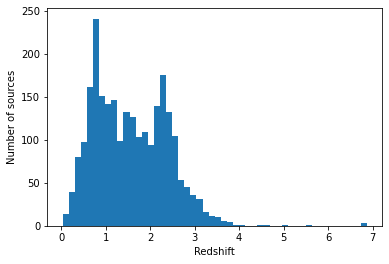

In [4]:
plt.hist(match_df['eFEDS_REDSHIFT'], bins=50)
plt.xlabel('Redshift')
plt.ylabel('Number of sources')

Consider only p_any>0.995 and det_like>10

In [6]:
matched_df = match_df[(match_df['p_any']>0.995) & (match_df['det_like']>10)]

In [7]:
updated_df = matched_df.copy()

Maybe consider only sources where counterpart quality >2 or >3?

Calculating redshift difference between eFEDS redshift and best redshift from sdss catalogue, as well average redshift between these 2, and adding them as columns in the dataframe. We also drop duplicates:

Code to return best redshift based on catalogue plate, mjd and catalogue fiber id:

In [10]:
t = updated_df['best_REDSHIFT'][(updated_df['CATALOG_PLATE']== 4735) & 
                            (updated_df['CATALOG_MJD']== 55651) & 
                            (updated_df['CATALOG_FIBERID']== 774)].iloc[0]
t

2.261

(0.0, 0.03)

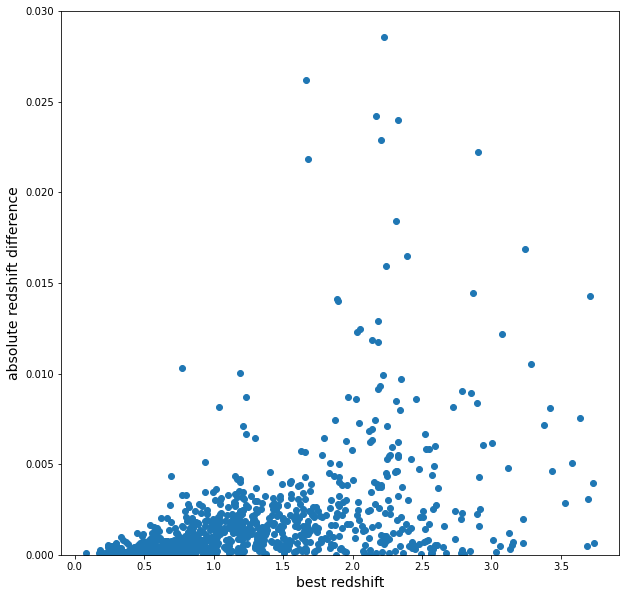

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(updated_df['best_REDSHIFT'], updated_df['redshift_difference'])
#plt.scatter(updated_df['average_redshift'][updated_df['redshift_difference']!=0], updated_df['redshift_difference'][updated_df['redshift_difference']!=0])
plt.xlabel('best redshift',fontsize=14)
plt.ylabel('absolute redshift difference',fontsize=14)
plt.ylim(0,0.03)